In [ ]:
pip install networkx torch torchvision torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s eta 0:00:00


# Import lib

In [ ]:
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

In [ ]:
from matplotlib import pyplot as plt

# Load data and visua

In [ ]:
G = nx.read_graphml("got-network.graphml")

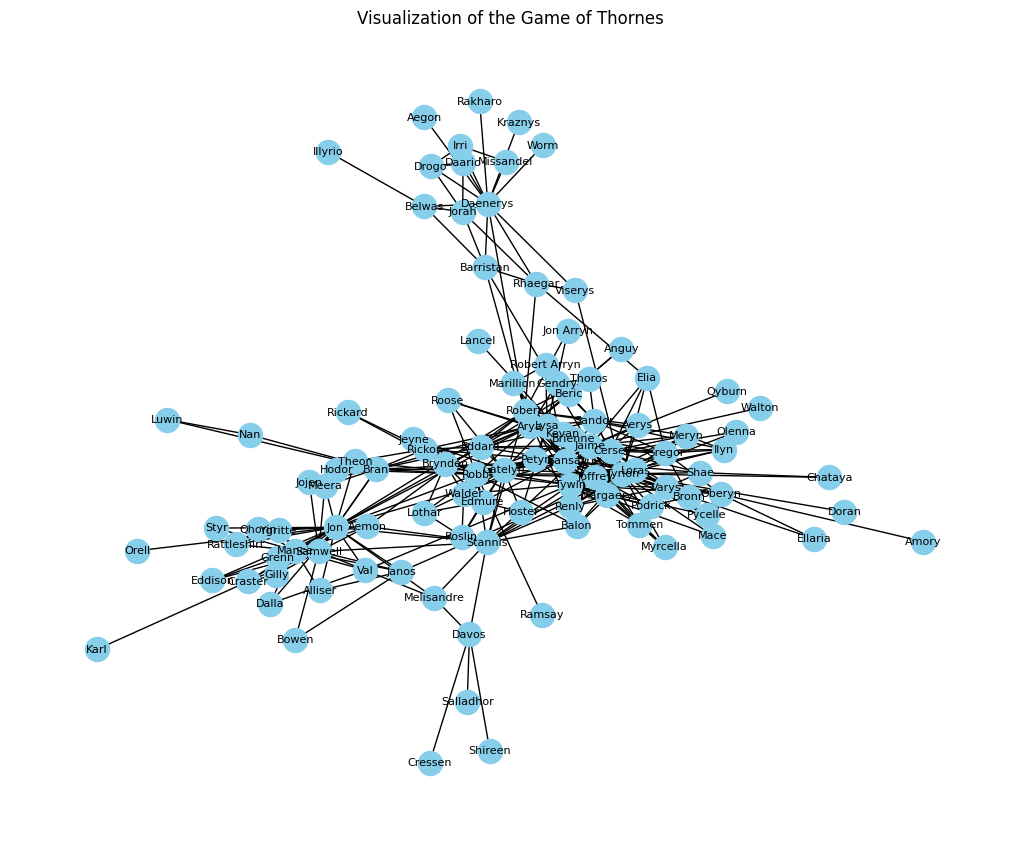

In [ ]:
# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=8, font_color="black")
plt.title("Visualization of the Game of Thornes")
plt.show()

In [ ]:
# Chuyển đổi sang định dạng torch_geometric
data = from_networkx(G)
print(data)

Data(edge_index=[2, 704], label=[107], weight=[704], id=[704], num_nodes=107)


# Split train test data

In [ ]:
import torch
from torch_geometric.utils import from_networkx

# Chuyển đổi từ NetworkX sang torch_geometric Data
data = from_networkx(G)

# Thêm node features (nếu chưa có), ví dụ: tạo đặc trưng đơn giản với giá trị 1
num_nodes = data.num_nodes
data.x = torch.ones((num_nodes, 1))  # Node features shape [num_nodes, num_features]

# Kiểm tra lại dữ liệu
print(data)


Data(edge_index=[2, 704], label=[107], weight=[704], id=[704], num_nodes=107, x=[107, 1])


In [ ]:
# Chuyển đổi edge_index thành tensor
if not isinstance(data.edge_index, torch.Tensor):
    edge_index = torch.tensor(data.edge_index, dtype=torch.long)
    data.edge_index = edge_index

# Kiểm tra lại
print("Edge index shape:", data.edge_index.shape)


Edge index shape: torch.Size([2, 704])


In [ ]:
num_nodes = data.num_nodes
data.x = torch.ones((num_nodes, 1))  # Node features với giá trị đơn giản là 1

In [ ]:
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

# Tạo một bản sao đơn giản của data chỉ với edge_index và x
simple_data = Data(edge_index=data.edge_index, x=data.x, num_nodes=data.num_nodes)

# Chia tập train, val, test
transform = RandomLinkSplit(
    num_val=0.1, num_test=0.1, is_undirected=True,
    add_negative_train_samples=False)

train_data, val_data, test_data = transform(simple_data)

print("Train edges:", train_data.edge_index.size(1))
print("Validation edges:", val_data.edge_index.size(1))
print("Test edges:", test_data.edge_index.size(1))


Train edges: 564
Validation edges: 564
Test edges: 634


# Train data

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Định nghĩa mô hình GCN
class GCNLinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNLinkPredictor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.link_predictor = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=1)

In [ ]:
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNLinkPredictor(in_channels=1, hidden_channels=16, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

# Hàm huấn luyện
def train():
    model.train()
    optimizer.zero_grad()

    # Encode node features
    z = model(train_data.x, train_data.edge_index)

    # Positive edges
    pos_edge_index = train_data.edge_index

    # Negative edges
    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=pos_edge_index.size(1)
    )

    # Dự đoán và tính loss
    pos_pred = model.decode(z, pos_edge_index)
    neg_pred = model.decode(z, neg_edge_index)

    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))]).to(device)

    loss = F.binary_cross_entropy_with_logits(preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# Hàm đánh giá
@torch.no_grad()
def test(data):
    model.eval()
    z = model(data.x, data.edge_index)

    # Positive edges
    pos_edge_index = data.edge_index

    # Negative edges
    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index, num_nodes=data.num_nodes,
        num_neg_samples=pos_edge_index.size(1)
    )

    # Dự đoán và tính AUC
    pos_pred = model.decode(z, pos_edge_index).sigmoid()
    neg_pred = model.decode(z, neg_edge_index).sigmoid()
    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))]).to(device)
    auc = roc_auc_score(labels.cpu(), preds.cpu())
    return auc

# Huấn luyện mô hình
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    print(f"Epoch {epoch}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}")

Epoch 1, Loss: 0.7149, Val AUC: 0.8015
Epoch 2, Loss: 0.6790, Val AUC: 0.7935
Epoch 3, Loss: 0.6716, Val AUC: 0.8039
Epoch 4, Loss: 0.6715, Val AUC: 0.8044
Epoch 5, Loss: 0.6745, Val AUC: 0.8200
Epoch 6, Loss: 0.6762, Val AUC: 0.7973
Epoch 7, Loss: 0.6775, Val AUC: 0.7928
Epoch 8, Loss: 0.6775, Val AUC: 0.7937
Epoch 9, Loss: 0.6773, Val AUC: 0.8023
Epoch 10, Loss: 0.6763, Val AUC: 0.7960
Epoch 11, Loss: 0.6773, Val AUC: 0.8050
Epoch 12, Loss: 0.6767, Val AUC: 0.8123
Epoch 13, Loss: 0.6755, Val AUC: 0.7976
Epoch 14, Loss: 0.6732, Val AUC: 0.8116
Epoch 15, Loss: 0.6767, Val AUC: 0.7883
Epoch 16, Loss: 0.6717, Val AUC: 0.8004
Epoch 17, Loss: 0.6718, Val AUC: 0.8128
Epoch 18, Loss: 0.6711, Val AUC: 0.8011
Epoch 19, Loss: 0.6699, Val AUC: 0.8339
Epoch 20, Loss: 0.6684, Val AUC: 0.8118
Epoch 21, Loss: 0.6675, Val AUC: 0.8085
Epoch 22, Loss: 0.6684, Val AUC: 0.7950
Epoch 23, Loss: 0.6650, Val AUC: 0.8051
Epoch 24, Loss: 0.6617, Val AUC: 0.8025
Epoch 25, Loss: 0.6648, Val AUC: 0.7968
Epoch 26,

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

@torch.no_grad()
def test(data):
    model.eval()
    z = model(data.x, data.edge_index)

    # Positive edges
    pos_edge_index = data.edge_index

    # Negative edges
    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index, num_nodes=data.num_nodes,
        num_neg_samples=pos_edge_index.size(1)
    )

    # Dự đoán xác suất
    pos_pred = model.decode(z, pos_edge_index).sigmoid()
    neg_pred = model.decode(z, neg_edge_index).sigmoid()
    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))]).to(device)

    # Chuyển dự đoán thành nhãn (0 hoặc 1)
    preds_label = (preds > 0.5).int()

    # Tính các metric
    auc = roc_auc_score(labels.cpu(), preds.cpu())
    acc = accuracy_score(labels.cpu(), preds_label.cpu())
    precision = precision_score(labels.cpu(), preds_label.cpu())
    recall = recall_score(labels.cpu(), preds_label.cpu())
    f1 = f1_score(labels.cpu(), preds_label.cpu())

    return auc, acc, precision, recall, f1

In [ ]:
# Huấn luyện mô hình
for epoch in range(1, 101):
    loss = train()
    val_auc, val_acc, val_precision, val_recall, val_f1 = test(val_data)
    # print(f"Epoch {epoch}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, "
    #       f"Accuracy: {val_acc:.4f}, Precision: {val_precision:.4f}, "
    #       f"Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")


In [ ]:
# Lưu kết quả theo từng epoch
val_results = {'auc': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
test_results = {'auc': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Vòng lặp huấn luyện
for epoch in range(1, 101):
    loss = train()
    val_auc, val_acc, val_precision, val_recall, val_f1 = test(val_data)
    test_auc, test_acc, test_precision, test_recall, test_f1 = test(test_data)

    # Lưu kết quả validation
    val_results['auc'].append(val_auc)
    val_results['accuracy'].append(val_acc)
    val_results['precision'].append(val_precision)
    val_results['recall'].append(val_recall)
    val_results['f1'].append(val_f1)

    # Lưu kết quả test
    test_results['auc'].append(test_auc)
    test_results['accuracy'].append(test_acc)
    test_results['precision'].append(test_precision)
    test_results['recall'].append(test_recall)
    test_results['f1'].append(test_f1)

    # print(f"Epoch {epoch}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}")


Epoch 1, Loss: 0.6095, Val AUC: 0.7441, Test AUC: 0.7496
Epoch 2, Loss: 0.6042, Val AUC: 0.7490, Test AUC: 0.7577
Epoch 3, Loss: 0.6195, Val AUC: 0.7517, Test AUC: 0.7588
Epoch 4, Loss: 0.6161, Val AUC: 0.7417, Test AUC: 0.7623
Epoch 5, Loss: 0.6132, Val AUC: 0.7554, Test AUC: 0.7615
Epoch 6, Loss: 0.6092, Val AUC: 0.7555, Test AUC: 0.7493
Epoch 7, Loss: 0.6085, Val AUC: 0.7434, Test AUC: 0.7391
Epoch 8, Loss: 0.6119, Val AUC: 0.7432, Test AUC: 0.7611
Epoch 9, Loss: 0.6090, Val AUC: 0.7470, Test AUC: 0.7453
Epoch 10, Loss: 0.6019, Val AUC: 0.7353, Test AUC: 0.7645
Epoch 11, Loss: 0.6175, Val AUC: 0.7602, Test AUC: 0.7644
Epoch 12, Loss: 0.6098, Val AUC: 0.7461, Test AUC: 0.7535
Epoch 13, Loss: 0.6156, Val AUC: 0.7282, Test AUC: 0.7593
Epoch 14, Loss: 0.6125, Val AUC: 0.7379, Test AUC: 0.7515
Epoch 15, Loss: 0.6054, Val AUC: 0.7552, Test AUC: 0.7663
Epoch 16, Loss: 0.5991, Val AUC: 0.7718, Test AUC: 0.7644
Epoch 17, Loss: 0.6135, Val AUC: 0.7395, Test AUC: 0.7702
Epoch 18, Loss: 0.6173,

In [ ]:
test_auc, test_acc, test_precision, test_recall, test_f1 = test(test_data)
print(f"Test Results - AUC: {test_auc:.4f}, Accuracy: {test_acc:.4f}, "
      f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

Test Results - AUC: 0.7527, Accuracy: 0.6136, Precision: 0.5796, Recall: 0.8265, F1-Score: 0.6814


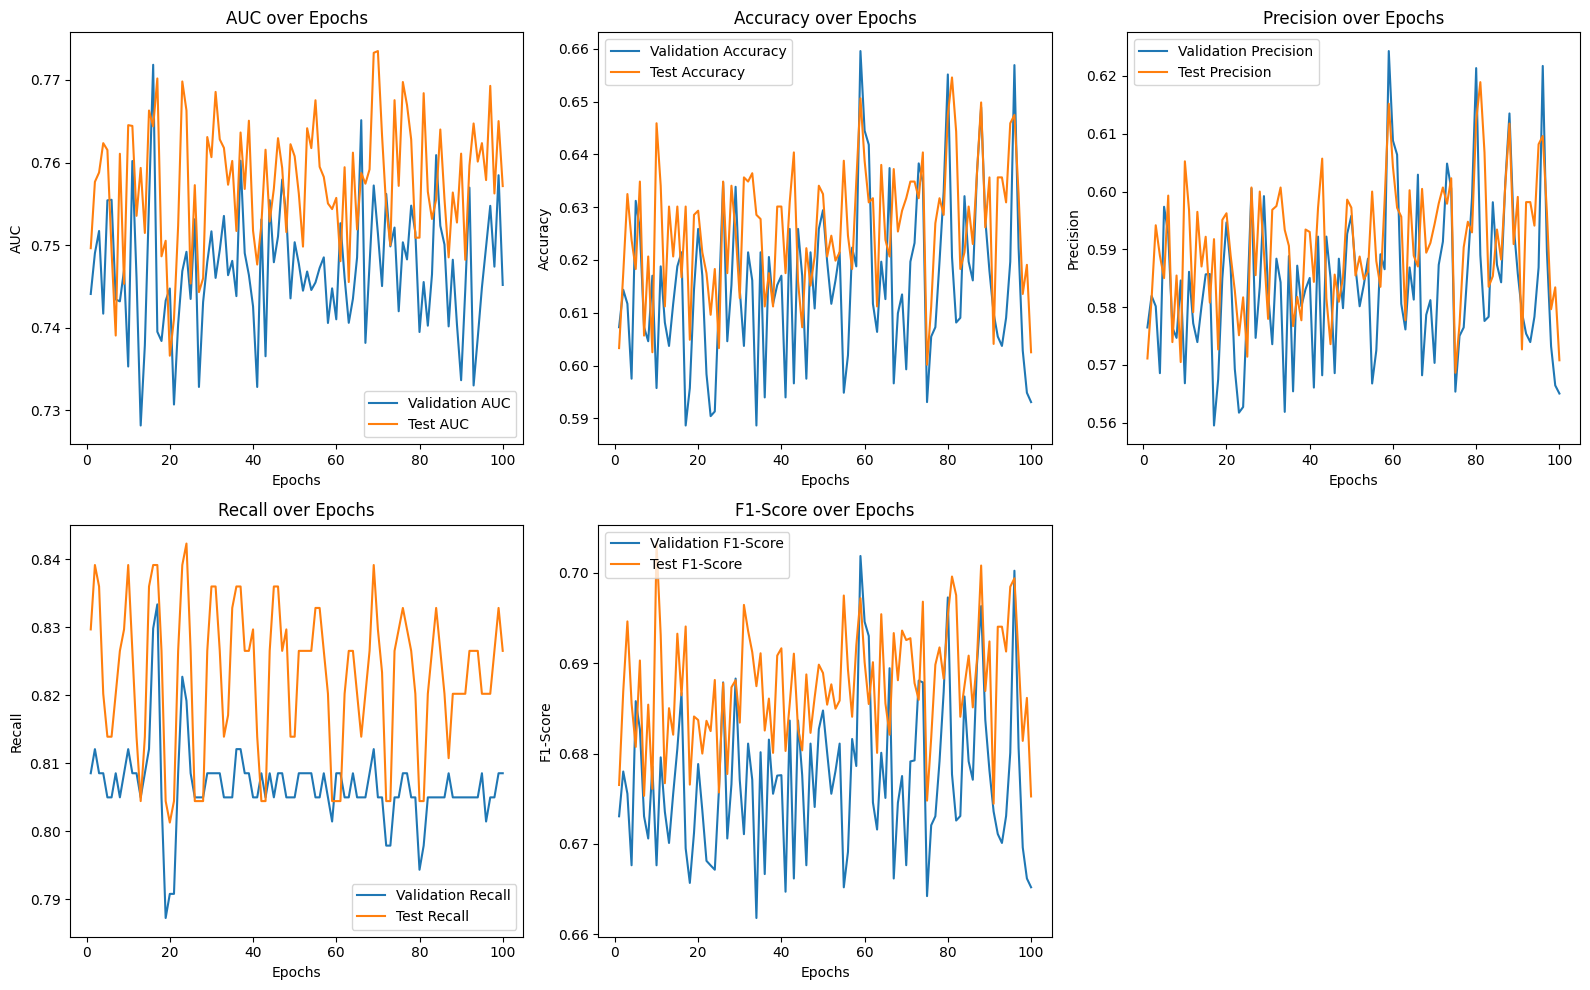

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đô
epochs = range(1, 101)

plt.figure(figsize=(16, 10))

# AUC
plt.subplot(2, 3, 1)
plt.plot(epochs, val_results['auc'], label="Validation AUC")
plt.plot(epochs, test_results['auc'], label="Test AUC")
plt.title("AUC over Epochs")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, val_results['accuracy'], label="Validation Accuracy")
plt.plot(epochs, test_results['accuracy'], label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Precision
plt.subplot(2, 3, 3)
plt.plot(epochs, val_results['precision'], label="Validation Precision")
plt.plot(epochs, test_results['precision'], label="Test Precision")
plt.title("Precision over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

# Recall
plt.subplot(2, 3, 4)
plt.plot(epochs, val_results['recall'], label="Validation Recall")
plt.plot(epochs, test_results['recall'], label="Test Recall")
plt.title("Recall over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()

# F1-Score
plt.subplot(2, 3, 5)
plt.plot(epochs, val_results['f1'], label="Validation F1-Score")
plt.plot(epochs, test_results['f1'], label="Test F1-Score")
plt.title("F1-Score over Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.legend()

plt.tight_layout()
plt.show()
